In [ ]:
pip install smogn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import smogn
import random
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from pandas.errors import PerformanceWarning

warnings.simplefilter(action="ignore", category=PerformanceWarning)


In [ ]:
df = pd.read_excel('/content/deduplicated_by_mode.xlsx')

columns_to_drop = [
    "Continent", "NCC-16-cases", "NCC-18-cases", "Low CIN-16-cases", "Low CIN-18-cases",
    "High CIN-16-cases", "High CIN-18-cases", "ICC - 16 - any - cases", "ICC - 16 - SCC - cases",
    "ICC - 16 - ADC - cases", "ICC - 18 - any - cases", "ICC - 18 - SCC - cases",
    "ICC - 18 - ADC - cases", 'Sample size studied', 'ICC prevalence',
    'High CIN prevalence', 'Low CIN prevalence'
]
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)


In [ ]:
df["TB_Incidence_Percent"] = (df["Incidence of TB"] / df["Population estimate"]) * 100
disease_cols = ["TB_Incidence_Percent", "Hypertension", "Diabetes Prevalence"]
df_norm = df[disease_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df["Disease_Incidence_Score"] = df_norm.mean(axis=1)
df.drop(columns=disease_cols, inplace=True)


In [ ]:
def convert_screening_year(value):
    if pd.isnull(value): return np.nan
    if isinstance(value, str) and value.strip().lower() in ["not started", "unknown"]:
        return 0
    try: return int(value)
    except: return np.nan

df["Screening_Start_Year"] = df["Start of Screening coverage (year)"].apply(convert_screening_year)

circumcision_col = "Male circumcision (WHO 2007)"
if circumcision_col in df.columns:
    df["Male circumcision category"] = df[circumcision_col].map({"<20": "Low", "20-80": "Medium", ">80": "High"})
    df.drop(columns=[circumcision_col], inplace=True)

sti_cols = [
    'STI_SyphilisRate_rateper100k_2021',
    'STI_ChlamydialInfectionRate_rateper100k_2021',
    'STDRates_GonococcalInfectionRate_rateper100k_2021'
]
df_sti_norm = df[sti_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df['STI_Score'] = df_sti_norm.mean(axis=1)
df.drop(columns=sti_cols, inplace=True)


In [ ]:
df['High_CIN_combined'] = df[['High CIN-16-prevalence', 'High CIN-18-prevalence']].mean(axis=1, skipna=True)

df.drop(columns=[
    "NCC-16-prevalence", "NCC-18-prevalence", "Low CIN-16-prevalence", "Low CIN-18-prevalence",
    "High CIN-16-prevalence", "High CIN-18-prevalence", "ICC - 16 - any - prevalence",
    "ICC - 16 - SCC - prevalence", "ICC - 16 - ADC - prevalence", "ICC - 18 - any - prevalence",
    "ICC - 18 - SCC - prevalence", "ICC - 18 - ADC - prevalence","Start of Screening coverage (year)"
], inplace=True)

df = df.dropna(subset=["High_CIN_combined"])


In [ ]:
X_all = df.drop(columns=["High_CIN_combined"])
y_all = df["High_CIN_combined"]

X_all = X_all.drop(columns=['Country', 'economy'], errors='ignore')  # Avoid high-cardinality dummy vars
X_encoded = pd.get_dummies(X_all, drop_first=True)

imputer = SimpleImputer(strategy='median')
X_encoded_imputed = imputer.fit_transform(X_encoded)

lasso = LassoCV(cv=5, random_state=42).fit(X_encoded_imputed, y_all)
selector = SelectFromModel(lasso, threshold=-np.inf, prefit=True)
selected_features = X_encoded.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_encoded_imputed[:, selector.get_support()], columns=selected_features)

df_stable = pd.concat([X_selected_df, y_all.reset_index(drop=True)], axis=1)


In [ ]:
np.random.seed(42)
random.seed(42)

df_smogn = smogn.smoter(
    data=df_stable,
    y="High_CIN_combined",
    k=5,
    samp_method='extreme',
    rel_thres=0.7
).copy()


r_index: 100%|##########| 2/2 [00:00<00:00, 98.87it/s]


In [ ]:
X = df_smogn.drop(columns=["High_CIN_combined"])
y = df_smogn["High_CIN_combined"]

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
X[categorical_cols] = X[categorical_cols].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [ ]:
best_params = {
    'n_estimators': 200,
    'max_depth': 4,
    'learning_rate': 0.010432920541221915,
    'subsample': 0.858663879924028,
    'colsample_bytree': 0.7469584920796172,
    'gamma': 2.85974989985308,
    'reg_alpha': 2.4259824683569735,
    'reg_lambda': 4.906137291714221
}

final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, **best_params))
])

final_model.fit(X_train, y_train)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


In [ ]:
def relative_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / np.mean(y_true)

print("🔧 Used Hyperparameters:", best_params)
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_test_pred):.4f}")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Test MSE:  {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"Train Relative RMSE: {relative_rmse(y_train, y_train_pred):.4f}")
print(f"Test Relative RMSE:  {relative_rmse(y_test, y_test_pred):.4f}")


🔧 Used Hyperparameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.010432920541221915, 'subsample': 0.858663879924028, 'colsample_bytree': 0.7469584920796172, 'gamma': 2.85974989985308, 'reg_alpha': 2.4259824683569735, 'reg_lambda': 4.906137291714221}
Train R²: 0.9052
Test R²:  0.8013
Train MSE: 20.1261
Test MSE:  47.9535
Train Relative RMSE: 0.1144
Test Relative RMSE:  0.1803


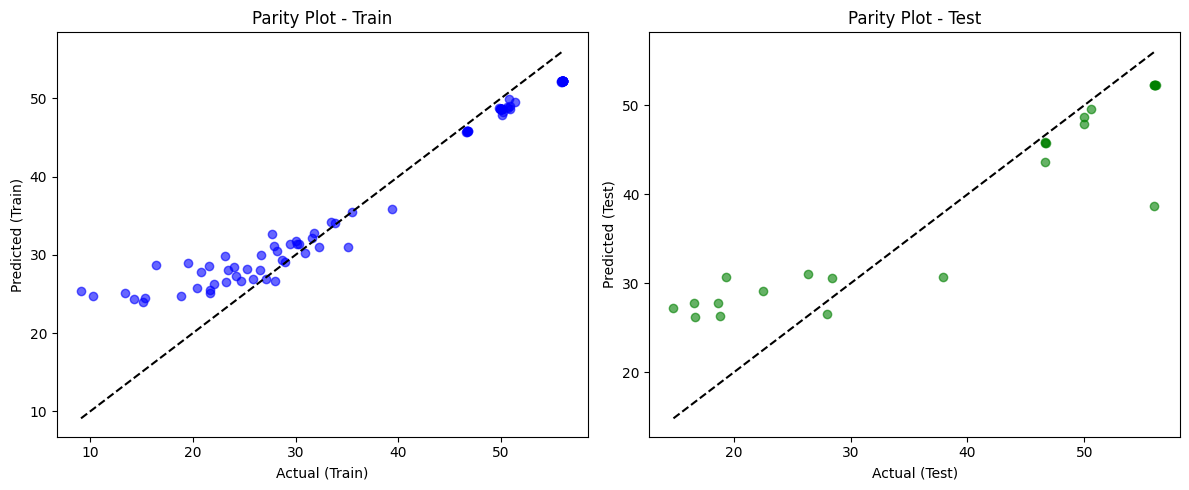

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.xlabel("Actual (Train)")
plt.ylabel("Predicted (Train)")
plt.title("Parity Plot - Train")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual (Test)")
plt.ylabel("Predicted (Test)")
plt.title("Parity Plot - Test")

plt.tight_layout()
plt.show()


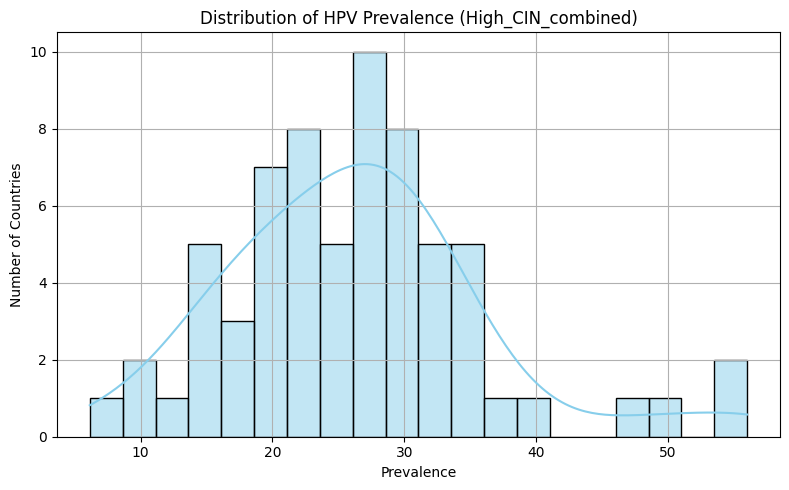

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df["High_CIN_combined"], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of HPV Prevalence (High_CIN_combined)")
plt.xlabel("Prevalence")
plt.ylabel("Number of Countries")
plt.grid(True)
plt.tight_layout()
plt.show()


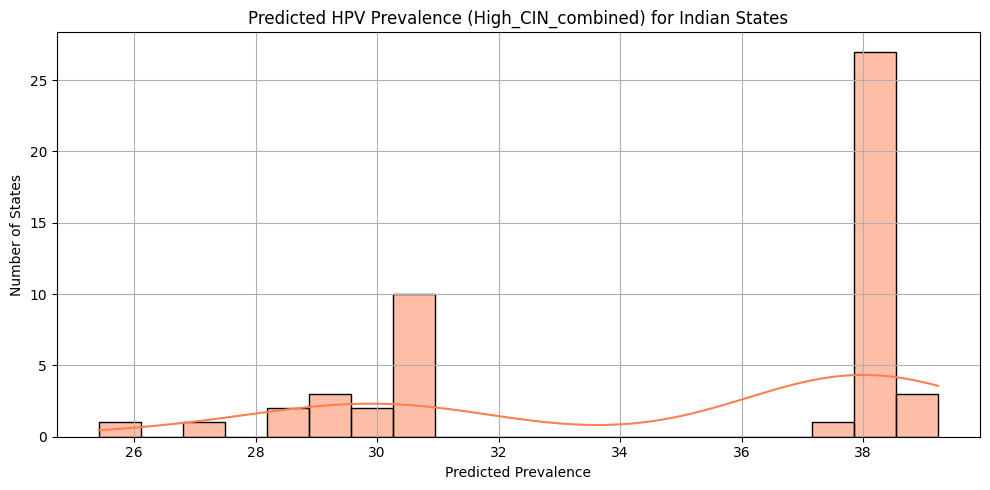

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📥 Step 1: Load the Indian data
india_df = pd.read_excel('/content/india_imputed_full_covariates7.xlsx')

# 🛠️ Step 2: Apply same feature engineering as world model
# TB Incidence %
india_df["TB_Incidence_Percent"] = (india_df["Incidence of TB"] / india_df["Population estimate"]) * 100

# Disease score normalization
disease_cols = ["TB_Incidence_Percent", "Hypertension", "Diabetes Prevalence"]
df_norm_india = india_df[disease_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
india_df["Disease_Incidence_Score"] = df_norm_india.mean(axis=1)
india_df.drop(columns=disease_cols, inplace=True)

# Handle screening year mapping
def convert_screening_year(value):
    if pd.isnull(value): return np.nan
    try: return int(value)
    except: return 0  # "Not started" and other strings

# ✅ Check before applying
if "Start of Screening coverage (year)" in india_df.columns:
    india_df["Screening_Start_Year"] = india_df["Start of Screening coverage (year)"].apply(convert_screening_year)
    india_df.drop(columns=["Start of Screening coverage (year)"], inplace=True)

# Circumcision mapping — only if column is categorical (string)
circumcision_col = "Male circumcision (WHO 2007)"
if circumcision_col in india_df.columns:
    if india_df[circumcision_col].dtype == object:
        india_df["Male circumcision category"] = india_df[circumcision_col].map({
            "<20": "Low", "20-80": "Medium", ">80": "High"
        })
        india_df.drop(columns=[circumcision_col], inplace=True)

# STI score
sti_cols = [
    'STI_SyphilisRate_rateper100k_2021',
    'STI_ChlamydialInfectionRate_rateper100k_2021',
    'STDRates_GonococcalInfectionRate_rateper100k_2021'
]
df_sti_india = india_df[sti_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
india_df['STI_Score'] = df_sti_india.mean(axis=1)
india_df.drop(columns=sti_cols, inplace=True)

# 🧹 Step 3: Drop columns not used in model
X_india = india_df.drop(columns=['State/UT'], errors='ignore')  # if your model was trained without it

# 🧠 Step 4: Predict using trained model
predicted_prevalence = final_model.predict(X_india)

# 📊 Step 5: Add predictions to dataframe
india_df['Predicted_High_CIN_combined'] = predicted_prevalence

# 💾 Step 6: Save to Excel
india_df.to_excel("india_predictions_High_cin_combined2.xlsx", index=False)

# ✅ Step 7: Plot predictions
plt.figure(figsize=(10, 5))
sns.histplot(predicted_prevalence, bins=20, kde=True, color='coral', edgecolor='black')
plt.title("Predicted HPV Prevalence (High_CIN_combined) for Indian States")
plt.xlabel("Predicted Prevalence")
plt.ylabel("Number of States")
plt.grid(True)
plt.tight_layout()
plt.show()
